
## Equation and problem definition
For a domain $\Omega \subset \mathbb{R}^n$ with boundary $\partial
\Omega = \Gamma_{D} \cup \Gamma_{N}$, the Poisson equation with
particular boundary conditions reads:
$$
\begin{align*}
- \nabla^{2} u &= f \quad {\rm in} \ \Omega, \\
u &= 0 \quad {\rm on} \ \Gamma_{D}, \\
\nabla u \cdot n &= g \quad {\rm on} \ \Gamma_{N}. \\
\end{align*}
$$
where $f$ and $g$ are input data and $n$ denotes the outward directed
boundary normal. The variational problem reads: find $u \in V$ such
that
$$
a(u, v) = L(v) \quad \forall \ v \in V,
$$
where $V$ is a suitable function space and
$$
\begin{align*}
a(u, v) &:= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\
L(v)    &:= \int_{\Omega} f v \, {\rm d} x + \int_{\Gamma_{N}} g v \, {\rm d} s.
\end{align*}
$$
The expression $a(u, v)$ is the bilinear form and $L(v)$
is the linear form. It is assumed that all functions in $V$
satisfy the Dirichlet boundary conditions ($u = 0 \ {\rm on} \
\Gamma_{D}$).
In this demo we consider:
- $\Omega = [0,2] \times [0,1]$ (a rectangle)
- $\Gamma_{D} = \{(0, y) \cup (2, y) \subset \partial \Omega\}$
- $\Gamma_{N} = \{(x, 0) \cup (x, 1) \subset \partial \Omega\}$
- $g = \sin(5x)$
- $f = 10\exp(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02)$

# Import the  modules to use in the example

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ufl
import dolfinx
from dolfinx.fem.petsc import LinearProblem
from dolfinx import fem, io, mesh, plot, geometry
from mpi4py import MPI
from petsc4py.PETSc import ScalarType

In [12]:
dolfinx.__version__

'0.8.0'

# Create mesh and define function space
See for details about meshing:
- https://docs.fenicsproject.org/dolfinx/v0.6.0/python/demos/demo_gmsh.html
- https://jorgensd.github.io/dolfinx-tutorial/chapter1/membrane_code.html
- https://jorgensd.github.io/dolfinx-tutorial/chapter2/ns_code2.html
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/subdomains.html

In [2]:
domain = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (2.0, 1.0)), n=(32, 16),
                            cell_type=mesh.CellType.triangle,)
V = fem.functionspace(domain, ("Lagrange", 1))

# Define variational problem

In [3]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(domain)
f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
g = ufl.sin(5 * x[0])
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = ufl.inner(f, v) * ufl.dx + ufl.inner(g, v) * ufl.ds

# Define the boundary conditions

We locate the mesh facets (`facets`) that lie on the boundary $\Gamma_D$ and their corresponding degrees-of-freedom that are associated (`dofs`)

See also:
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/neumann_dirichlet_code.html


In [4]:
facets = mesh.locate_entities_boundary(domain, dim=1,
                                       marker=lambda x: np.logical_or(np.isclose(x[0], 0.0),
                                                                      np.isclose(x[0], 2.0)))
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

# Compute solution

`FEniCSx` use `PETSc` for linear algebra, linear and nonlinear solvers. See https://petsc.org/release/docs/manual/ for the solver options.

In [5]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# Plot and save the solution


We can save the solution to a file in modern formats, that can be read with `paraview`. 
See:
- Download paraview: https://www.paraview.org/download/
- https://jorgensd.github.io/dolfinx-tutorial/chapter1/membrane_paraview.html
- Paraview documentatiosn: https://docs.paraview.org/en/latest/

In [6]:
with io.XDMFFile(domain.comm, "output/output.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

We can also use pyvista for interactive plotting and directly generate figures programmatically, see
- https://docs.fenicsproject.org/dolfinx/v0.5.1/python/demos/demo_pyvista.html
- https://docs.pyvista.org
- https://jorgensd.github.io/dolfinx-tutorial/chapter1/fundamentals_code.html
- https://jorgensd.github.io/dolfinx-tutorial/chapter1/membrane_code.html

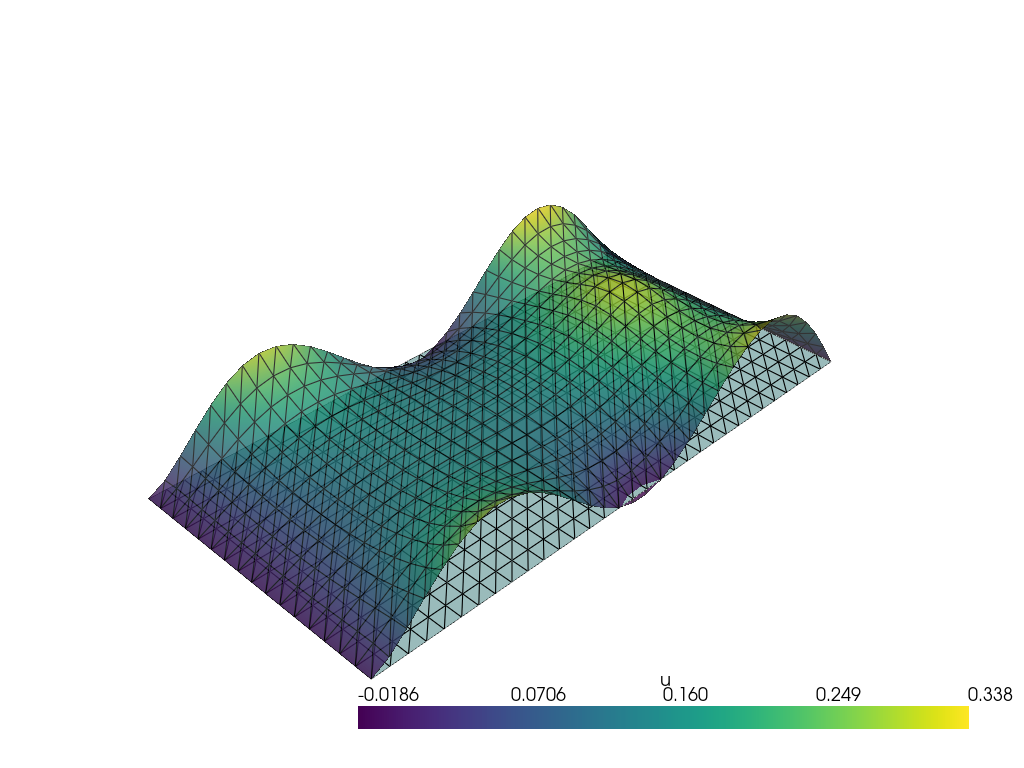

In [7]:
from dolfinx.plot import vtk_mesh
import pyvista


pyvista.OFF_SCREEN = False

pyvista.start_xvfb()
pyvista.set_jupyter_backend("static")

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

# Set deflection values and add it to plotter
grid.point_data["u"] = uh.x.array
warped = grid.warp_by_scalar("u", factor=1)

plotter = pyvista.Plotter()
grid_0 = pyvista.UnstructuredGrid(topology, cell_types, x)
plotter.add_mesh(grid_0, show_edges=True)
plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="u",opacity=0.8)

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot("deflection.png")

# Further details and more advanced features

## Making curve plots throughout the domain



We can evaluate a function on a point by using the  `uh.eval(points, cells)`, which requires the lists of cells where the points lie. To get this information we can use the following utility function, see
- https://jorgensd.github.io/dolfinx-tutorial/chapter1/membrane_code.html

In [8]:
def data_over_line(points, function):
    mesh = function.function_space.mesh
    comm = mesh.comm
    # comm
    bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
    cells = []
    points_on_proc = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
    # Choose one of the cells that contains the point
    colliding_cells = geometry.compute_colliding_cells(
        mesh, cell_candidates, points.T
    )
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    points_on_proc = np.array(points_on_proc)

    if len(points_on_proc) > 0:
        values_on_proc = function.eval(points_on_proc, cells)
        point_data_proc = [points_on_proc.T, values_on_proc]
    else:
        point_data_proc = None

    point_data = comm.gather(point_data_proc, root=0)

    if comm.rank == 0:
        point_data = list(filter(None, point_data))
        # points = np.concatenate([data_proc[0].T for data_proc in point_data])
        values = np.concatenate([data_proc[1] for data_proc in point_data])
    else:
        point_data = None
        values = None
    return values

Defines the list of points, get the correspoding cells, and evaluate the function values

In [9]:
xs = np.linspace(0,1,101)
points = np.array([np.ones_like(xs), xs, np.zeros_like(xs)])
values = data_over_line(points,uh)

We can then make a plot with matplotlib

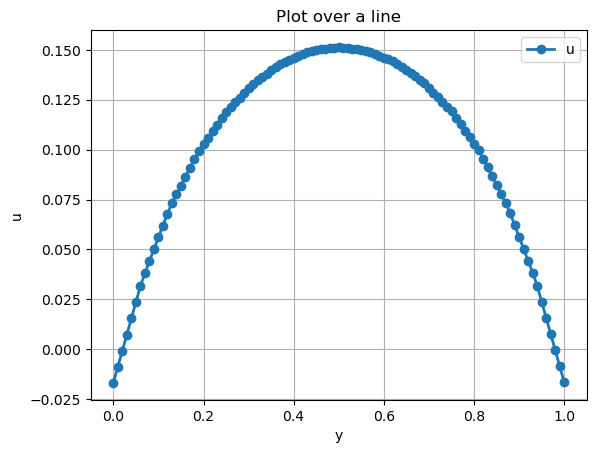

<Figure size 640x480 with 0 Axes>

In [10]:
fig = plt.figure()
plt.plot(points[1], values, "-o", linewidth=2, label="u")
plt.grid(True)
plt.xlabel("y")
plt.ylabel("u")
plt.title("Plot over a line")
plt.legend()
plt.show()
plt.savefig(f"output/line_plot.png")

## What is behind `LinearProblem.solve()`

See also
 - https://jorgensd.github.io/dolfinx-tutorial/chapter4/solvers.html

In [11]:
# Assemble matrix and vector from bilinear and linear form
A = fem.petsc.assemble_matrix(fem.form(a),bcs=[bc])
b = fem.petsc.assemble_vector(fem.form(L))
fem.apply_lifting(b, [fem.form(a)], bcs=[[bc]])
A.assemble()

# Create LU linear solver (use petsc4py)
from petsc4py import PETSc
solver = PETSc.KSP().create(MPI.COMM_WORLD)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)
solver.setOperators(A)

# Solve the linear system
uh = fem.Function(V)
solver.solve(b, uh.vector)
uh.x.scatter_forward()

We can convert the vector and matrix to numpy (attention to memory for `A`) to inspect them

[-1.61002180e-02 -3.11453699e-02 -3.40013194e-02  1.65107663e-49
  3.08461220e-03 -3.40013194e-02  8.12940360e-46  2.20753710e-48
  2.19706542e-02 -3.40013194e-02]


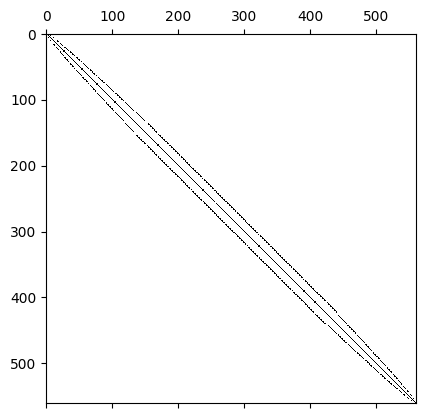

In [12]:
plt.spy(A.convert("dense").getDenseArray())
print(b.array[0:10])